In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pickle
import os
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


with open('/home/jhmoon/venvFL/2023-paper-Federated_Learning/Data/mHealth/mhealth_raw_data.pickle', 'rb') as f:
    df = pickle.load(f)

from sklearn.utils import resample
 
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples = 30000, random_state = 42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

#Dropping feature have data outside 98% confidence interval
df1 = df.copy()
for feature in df1.columns[:-1]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)

label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

#spliting data into train and test set
print(df1.shape)
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape


X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity', 'subject'],axis=1)
y_test = test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

# X_train: DF


/home/jhmoon/venvFL/env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


alx range: -11.47312 to 19.233
shape (365733, 14)
aly range: -19.379 to 2.447871999999997
shape (360018, 14)
alz range: -18.95 to 14.19623999999999
shape (356270, 14)
glx range: -0.74212 to 0.80705
shape (349377, 14)
gly range: -1.0694 to 0.96623
shape (342841, 14)
glz range: -1.1061 to 0.8290799999999999
shape (337391, 14)
arx range: -21.492 to 9.097647999999998
shape (332307, 14)
ary range: -18.694000000000003 to 11.948059999999998
shape (326241, 14)
arz range: -10.367 to 11.823119999999996
shape (323674, 14)
grx range: -1.0196 to 0.95686
shape (320188, 14)
gry range: -1.1417 to 0.90965
shape (315352, 14)
grz range: -0.69828 to 1.125
shape (310929, 14)
Activity range: 0.0 to 12.0
shape (310929, 14)
(310929, 14)


((246501, 12), (246501,), (64428, 12), (64428,))

In [2]:
torch.manual_seed(34)

In [3]:
from scipy import stats

#function to create time series datset for seuence modeling
# Repeat 4929 times
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [4]:
X_tr_modal1 = X_train.iloc[:, :6]
X_tr_modal2 = X_train.iloc[:, 6:]
X_tr_modal3 = X_train.copy()

y_tr_modal = y_train.copy()

X_ts_modal1 = X_test.iloc[:, :6]
X_ts_modal2 = X_test.iloc[:, 6:]
X_ts_modal3 = X_test.copy()

y_ts_modal = y_test.copy()

In [5]:
X_tr_modal1

,alx,aly,alz,glx,gly,glz
154060,-0.68636,-5.2902,4.64530,0.13544,-0.83114,-0.13163
936066,1.00030,-7.7902,-6.74410,-0.26531,-0.14447,-1.09820
167106,1.53220,-9.5966,-0.25618,-0.27273,-0.75985,0.63654
493889,1.78090,-8.5942,-3.97440,-0.41002,-0.55535,-0.78389
355024,-0.34940,-9.5201,1.45800,-0.68275,-0.77861,-0.24558
...,...,...,...,...,...,...
978518,4.95120,-2.8483,-3.64500,-0.52876,-0.72795,-0.67387
978519,5.72820,-1.1482,-6.89600,-0.48052,-0.82927,-0.59725
978520,7.27720,-1.4694,-4.36530,-0.48052,-0.82927,-0.59725
978523,4.22170,-18.8880,3.28530,-0.38590,-0.72233,-0.77603


In [12]:
X_train, y_train = create_dataset(X_tr_modal1, y_tr_modal, 10, step=5)
X_test, y_test = create_dataset(X_ts_modal1, y_ts_modal, 10, step=5)

In [15]:
X_train[0]

array([[ -0.68636,  -5.2902 ,   4.6453 ,   0.13544,  -0.83114,  -0.13163],
       [  1.0003 ,  -7.7902 ,  -6.7441 ,  -0.26531,  -0.14447,  -1.0982 ],
       [  1.5322 ,  -9.5966 ,  -0.25618,  -0.27273,  -0.75985,   0.63654],
       [  1.7809 ,  -8.5942 ,  -3.9744 ,  -0.41002,  -0.55535,  -0.78389],
       [ -0.3494 ,  -9.5201 ,   1.458  ,  -0.68275,  -0.77861,  -0.24558],
       [  1.4099 ,  -9.8865 ,  -0.53231,   0.59184,  -0.66604,   0.05501],
       [ -0.25623,  -9.8694 ,  -0.79811,   0.26716,  -0.61914,  -0.40472],
       [  2.6704 ,  -8.8709 ,   1.0311 ,   0.3859 ,  -0.62477,   0.51277],
       [ -0.54737, -19.355  ,  -8.7857 ,  -0.56957,  -0.5197 ,  -0.7721 ],
       [  2.3344 , -19.096  ,   9.2456 ,  -0.50278,  -0.35272,  -0.91356]])

In [16]:
X_train[1]

array([[  1.4099  ,  -9.8865  ,  -0.53231 ,   0.59184 ,  -0.66604 ,
          0.05501 ],
       [ -0.25623 ,  -9.8694  ,  -0.79811 ,   0.26716 ,  -0.61914 ,
         -0.40472 ],
       [  2.6704  ,  -8.8709  ,   1.0311  ,   0.3859  ,  -0.62477 ,
          0.51277 ],
       [ -0.54737 , -19.355   ,  -8.7857  ,  -0.56957 ,  -0.5197  ,
         -0.7721  ],
       [  2.3344  , -19.096   ,   9.2456  ,  -0.50278 ,  -0.35272 ,
         -0.91356 ],
       [  0.13529 ,  -9.6352  ,   0.83209 ,  -0.64007 ,  -0.73171 ,
          0.32417 ],
       [  0.49466 ,  -4.8068  ,  -8.4021  ,  -0.068646,  -0.98311 ,
         -0.37525 ],
       [ -0.115   ,  -7.9223  ,  -4.116   ,  -0.45083 ,  -0.16323 ,
         -0.93517 ],
       [  2.4473  , -13.509   ,   0.60945 ,  -0.43228 ,  -0.77674 ,
         -0.65226 ],
       [ -2.2128  ,  -9.7367  ,  -0.4048  ,   0.21707 ,  -0.87617 ,
         -0.53438 ]])

In [271]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_modal1 = scaler.fit_transform(X_tr_modal1.values)
X_tr_modal1 = pd.DataFrame(X_tr_modal1)

scaler1 = StandardScaler()
X_ts_modal1 = scaler1.fit_transform(X_ts_modal1.values)
X_ts_modal1 = pd.DataFrame(X_ts_modal1)

In [4]:
from scipy import stats

#function to create time series datset for seuence modeling
# Repeat 4929 times
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [6]:
class ConvLSTM12(nn.Module):
    def __init__(self):
        super(ConvLSTM12, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=13)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        # print(f"Round {self.round} initialized")
        # Convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)

        # LSTM layer
        x = x.permute(0, 2, 1)  # Change from (batch_size, seq_len, num_features) to (batch_size, num_features, seq_len)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Extract the last timestep output


        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

class ConvLSTM6(nn.Module):
    def __init__(self):
        super(ConvLSTM6, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=6, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=128, out_features=13)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        # print(f"Round {self.round} initialized")
        # Convolutional layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)

        # LSTM layer
        x = x.permute(0, 2, 1)  # Change from (batch_size, seq_len, num_features) to (batch_size, num_features, seq_len)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Extract the last timestep output


        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import random

def modalTest(model, X_train, y_train, X_test, y_test, epoch, time_step, step):
    X_train, y_train = create_dataset(X_train, y_train, time_step, step)
    X_test, y_test = create_dataset(X_test, y_test, time_step, step)
    print(X_train.shape, y_train.shape)

# 100, 50

    X_train = np.transpose(X_train, (0, 2, 1))
    X_test = np.transpose(X_test, (0, 2, 1))

    X_train = torch.from_numpy(X_train).float().to(DEVICE)
    y_train = torch.from_numpy(y_train).long().to(DEVICE)

    X_test = torch.from_numpy(X_test).float().to(DEVICE)
    y_test = torch.from_numpy(y_test).long().to(DEVICE)


    yvalues = pd.Series(y_train.squeeze().cpu().numpy())
    yvaluess = pd.Series(y_test.squeeze().cpu().numpy())
    ytr = []
    yts = []
    for i in range(12):
        ytr.append(yvalues[yvalues == i].index.to_list())
        yts.append(yvaluess[yvaluess == i].index.to_list())

    m1tr_index = []
    m2tr_index = []
    m3tr_index = []

    m1v_index = []
    m2v_index = []
    m3v_index = []

    m1ts_index = []
    m2ts_index = []
    m3ts_index = []

    for i in range(12):
        m1tr_index += np.random.choice(ytr[i], 72, replace=False).tolist()
        m2tr_index += np.random.choice(ytr[i], 72, replace=False).tolist()
        m3tr_index += np.random.choice(ytr[i], 72, replace=False).tolist()

        m1v_index += np.random.choice(ytr[i], 24, replace=False).tolist()
        m2v_index += np.random.choice(ytr[i], 24, replace=False).tolist()
        m3v_index += np.random.choice(ytr[i], 24, replace=False).tolist()

        m1ts_index += np.random.choice(yts[i], 30, replace=False).tolist()
        m2ts_index += np.random.choice(yts[i], 30, replace=False).tolist()
        m3ts_index += np.random.choice(yts[i], 30, replace=False).tolist()

    m1tr_index = random.sample(m1tr_index, len(m1tr_index))
    m2tr_index = random.sample(m2tr_index, len(m2tr_index))
    m3tr_index = random.sample(m3tr_index, len(m3tr_index))

    m1v_index = random.sample(m1v_index, len(m1v_index))
    m2v_index = random.sample(m2v_index, len(m2v_index))
    m3v_index = random.sample(m3v_index, len(m3v_index))

    m1ts_index = random.sample(m1ts_index, len(m1ts_index))
    m2ts_index = random.sample(m2ts_index, len(m2ts_index))
    m3ts_index = random.sample(m3ts_index, len(m3ts_index))

    X_trains = [X_train[m1tr_index], X_train[m2tr_index], X_train[m3tr_index]]
    y_trains = [y_train[m1tr_index], y_train[m2tr_index], y_train[m3tr_index]]
    X_vals = [X_train[m1v_index], X_train[m2v_index], X_train[m3v_index]]
    y_vals = [y_train[m1v_index], y_train[m2v_index], y_train[m3v_index]]
    X_test = X_test[m1ts_index]
    y_test = y_test[m1ts_index]

    model = model.to(DEVICE)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    def train(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, epochs=10, device=DEVICE):
        train_acc = []
        test_acc = []
        train_loss =[]
        test_loss = []
        for epoch in tqdm(range(epochs)):
            model.train()
            optimizer.zero_grad()
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train.squeeze())
            loss.backward()
            optimizer.step()
            model.eval()
            with torch.no_grad():
                y_pred_train = model(X_train)
                y_pred_test = model(X_test)
                train_acc.append(accuracy_score(y_train.cpu(), y_pred_train.cpu().argmax(1)))
                test_acc.append(accuracy_score(y_test.cpu(), y_pred_test.cpu().argmax(1)))
                train_loss.append(loss.item())
                if epoch % 9 == 0:
                    print('Epoch: {} Train Loss: {:.4f} Train Acc: {:.4f} Test Acc: {:.4f}'.format(epoch, loss.item(), train_acc[-1], test_acc[-1]))
        return train_acc, test_acc, train_loss


    train_acc, test_acc, train_loss = train(model, X_trains[0], y_trains[0], X_test, y_test, optimizer, loss_fn, epochs= epoch, device = DEVICE)

    plt.plot(train_acc, label='train', color = 'b')

    plt.plot(test_acc, label='test', color = 'r')

    # plt.plot(train_loss, label = 'train_loss', color = 'yellow')

    plt.legend()

    plt.show()
    return 

(4929, 100, 6) (4929, 1)


  3%|▎         | 3/100 [00:00<00:04, 24.15it/s]

Epoch: 0 Train Loss: 2.5651 Train Acc: 0.0833 Test Acc: 0.0861


 18%|█▊        | 18/100 [00:00<00:02, 34.67it/s]

Epoch: 10 Train Loss: 2.5520 Train Acc: 0.1620 Test Acc: 0.1278


 26%|██▌       | 26/100 [00:00<00:02, 35.76it/s]

Epoch: 20 Train Loss: 2.4910 Train Acc: 0.2488 Test Acc: 0.2167


 38%|███▊      | 38/100 [00:01<00:01, 36.50it/s]

Epoch: 30 Train Loss: 2.3698 Train Acc: 0.4340 Test Acc: 0.4111


 46%|████▌     | 46/100 [00:01<00:01, 36.32it/s]

Epoch: 40 Train Loss: 2.2811 Train Acc: 0.4155 Test Acc: 0.4111


 58%|█████▊    | 58/100 [00:01<00:01, 36.56it/s]

Epoch: 50 Train Loss: 2.2280 Train Acc: 0.4201 Test Acc: 0.4111


 66%|██████▌   | 66/100 [00:01<00:00, 36.46it/s]

Epoch: 60 Train Loss: 2.1322 Train Acc: 0.5880 Test Acc: 0.5667


 78%|███████▊  | 78/100 [00:02<00:00, 36.40it/s]

Epoch: 70 Train Loss: 2.0530 Train Acc: 0.6956 Test Acc: 0.6639


 86%|████████▌ | 86/100 [00:02<00:00, 36.34it/s]

Epoch: 80 Train Loss: 1.9235 Train Acc: 0.7789 Test Acc: 0.7056


 98%|█████████▊| 98/100 [00:02<00:00, 36.37it/s]

Epoch: 90 Train Loss: 1.8711 Train Acc: 0.8576 Test Acc: 0.7639


100%|██████████| 100/100 [00:02<00:00, 35.71it/s]


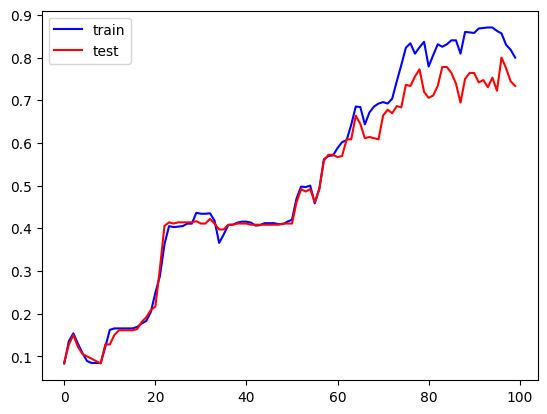

In [15]:
model = ConvLSTM6()
modalTest(model, X_tr_modal1, y_tr_modal, X_ts_modal1, y_ts_modal, 100, 100, 50)

In [16]:
steps = [[20, 10], [30, 15], [40, 20], [50, 25], [60, 30], [70, 35], [80, 40], [90, 45], [100, 50]]

[20, 10]
(24649, 20, 12) (24649, 1)


  7%|▋         | 7/100 [00:00<00:01, 61.63it/s]

Epoch: 0 Train Loss: 2.5650 Train Acc: 0.0891 Test Acc: 0.0833
Epoch: 10 Train Loss: 2.5506 Train Acc: 0.2083 Test Acc: 0.1944


 27%|██▋       | 27/100 [00:00<00:00, 87.94it/s]

Epoch: 20 Train Loss: 2.4726 Train Acc: 0.3009 Test Acc: 0.3333
Epoch: 30 Train Loss: 2.3483 Train Acc: 0.4653 Test Acc: 0.4389


 39%|███▉      | 39/100 [00:00<00:00, 98.55it/s]

Epoch: 40 Train Loss: 2.1672 Train Acc: 0.6586 Test Acc: 0.6472


 63%|██████▎   | 63/100 [00:00<00:00, 110.13it/s]

Epoch: 50 Train Loss: 2.0246 Train Acc: 0.7743 Test Acc: 0.6806
Epoch: 60 Train Loss: 1.9073 Train Acc: 0.8241 Test Acc: 0.7028
Epoch: 70 Train Loss: 1.8226 Train Acc: 0.8854 Test Acc: 0.7528


 87%|████████▋ | 87/100 [00:00<00:00, 112.18it/s]

Epoch: 80 Train Loss: 1.7823 Train Acc: 0.9097 Test Acc: 0.7611
Epoch: 90 Train Loss: 1.7702 Train Acc: 0.9178 Test Acc: 0.7528


100%|██████████| 100/100 [00:00<00:00, 104.56it/s]


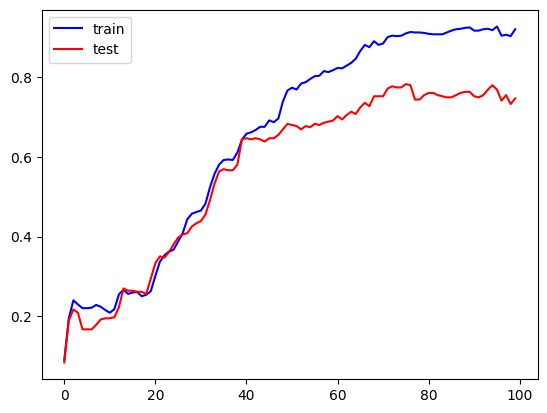

[30, 15]
(16432, 30, 12) (16432, 1)


  6%|▌         | 6/100 [00:00<00:01, 53.62it/s]

Epoch: 0 Train Loss: 2.5648 Train Acc: 0.0833 Test Acc: 0.0833
Epoch: 10 Train Loss: 2.5511 Train Acc: 0.2812 Test Acc: 0.2528


 22%|██▏       | 22/100 [00:00<00:01, 69.69it/s]

Epoch: 20 Train Loss: 2.4735 Train Acc: 0.3356 Test Acc: 0.3333


 32%|███▏      | 32/100 [00:00<00:00, 79.90it/s]

Epoch: 30 Train Loss: 2.3086 Train Acc: 0.4711 Test Acc: 0.4750


 42%|████▏     | 42/100 [00:00<00:00, 86.10it/s]

Epoch: 40 Train Loss: 2.1541 Train Acc: 0.6134 Test Acc: 0.5778


 52%|█████▏    | 52/100 [00:00<00:00, 89.60it/s]

Epoch: 50 Train Loss: 2.0241 Train Acc: 0.6678 Test Acc: 0.6194


 62%|██████▏   | 62/100 [00:00<00:00, 91.57it/s]

Epoch: 60 Train Loss: 1.9346 Train Acc: 0.7917 Test Acc: 0.7250


 72%|███████▏  | 72/100 [00:00<00:00, 93.80it/s]

Epoch: 70 Train Loss: 1.8867 Train Acc: 0.7940 Test Acc: 0.6806


 82%|████████▏ | 82/100 [00:00<00:00, 95.34it/s]

Epoch: 80 Train Loss: 1.8517 Train Acc: 0.8634 Test Acc: 0.8056


100%|██████████| 100/100 [00:01<00:00, 88.61it/s]

Epoch: 90 Train Loss: 1.8175 Train Acc: 0.8715 Test Acc: 0.7833


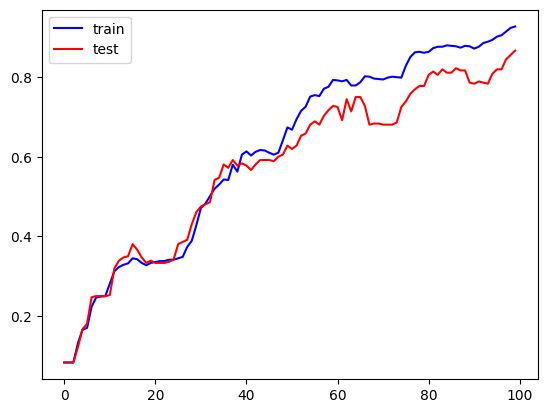

[40, 20]
(12324, 40, 12) (12324, 1)


  5%|▌         | 5/100 [00:00<00:02, 45.74it/s]

Epoch: 0 Train Loss: 2.5651 Train Acc: 0.0914 Test Acc: 0.0861


 24%|██▍       | 24/100 [00:00<00:01, 60.68it/s]

Epoch: 10 Train Loss: 2.5540 Train Acc: 0.2940 Test Acc: 0.2694
Epoch: 20 Train Loss: 2.4915 Train Acc: 0.3981 Test Acc: 0.4028


 40%|████      | 40/100 [00:00<00:00, 69.92it/s]

Epoch: 30 Train Loss: 2.3179 Train Acc: 0.5127 Test Acc: 0.4667
Epoch: 40 Train Loss: 2.1253 Train Acc: 0.7373 Test Acc: 0.6361


 64%|██████▍   | 64/100 [00:00<00:00, 75.10it/s]

Epoch: 50 Train Loss: 1.9466 Train Acc: 0.7940 Test Acc: 0.6083
Epoch: 60 Train Loss: 1.8700 Train Acc: 0.8264 Test Acc: 0.6583


 80%|████████  | 80/100 [00:01<00:00, 75.96it/s]

Epoch: 70 Train Loss: 1.8040 Train Acc: 0.9606 Test Acc: 0.7778
Epoch: 80 Train Loss: 1.7352 Train Acc: 0.9664 Test Acc: 0.7333


100%|██████████| 100/100 [00:01<00:00, 70.27it/s]


Epoch: 90 Train Loss: 1.7174 Train Acc: 0.9803 Test Acc: 0.7944


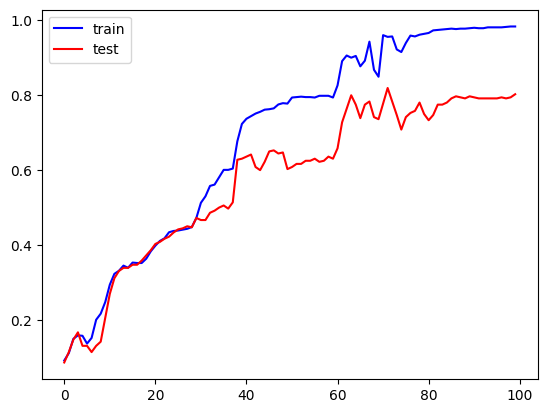

[50, 25]
(9859, 50, 12) (9859, 1)


  4%|▍         | 4/100 [00:00<00:02, 38.88it/s]

Epoch: 0 Train Loss: 2.5649 Train Acc: 0.0833 Test Acc: 0.0833


 21%|██        | 21/100 [00:00<00:01, 53.53it/s]

Epoch: 10 Train Loss: 2.5491 Train Acc: 0.2130 Test Acc: 0.2194
Epoch: 20 Train Loss: 2.4808 Train Acc: 0.2697 Test Acc: 0.2667


 42%|████▏     | 42/100 [00:00<00:00, 60.77it/s]

Epoch: 30 Train Loss: 2.3732 Train Acc: 0.4132 Test Acc: 0.3944
Epoch: 40 Train Loss: 2.2166 Train Acc: 0.5312 Test Acc: 0.5167


 63%|██████▎   | 63/100 [00:01<00:00, 62.55it/s]

Epoch: 50 Train Loss: 2.0969 Train Acc: 0.6898 Test Acc: 0.6278
Epoch: 60 Train Loss: 1.9815 Train Acc: 0.7859 Test Acc: 0.6972


 77%|███████▋  | 77/100 [00:01<00:00, 61.89it/s]

Epoch: 70 Train Loss: 1.8807 Train Acc: 0.8194 Test Acc: 0.7389
Epoch: 80 Train Loss: 1.8098 Train Acc: 0.9549 Test Acc: 0.8500


100%|██████████| 100/100 [00:01<00:00, 59.55it/s]

Epoch: 90 Train Loss: 1.7369 Train Acc: 0.9630 Test Acc: 0.8667


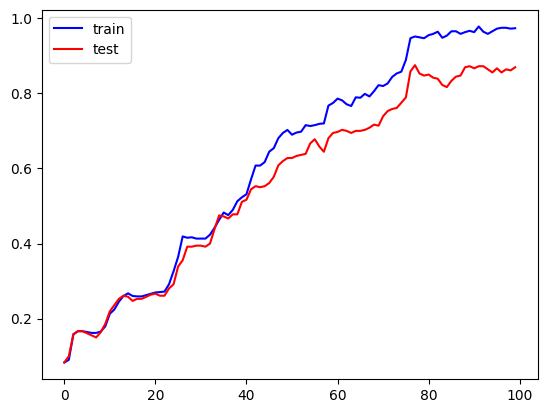

[60, 30]
(8215, 60, 12) (8215, 1)


  6%|▌         | 6/100 [00:00<00:01, 55.99it/s]

Epoch: 0 Train Loss: 2.5648 Train Acc: 0.0833 Test Acc: 0.0833
Epoch: 10 Train Loss: 2.5538 Train Acc: 0.2407 Test Acc: 0.2389


 18%|█▊        | 18/100 [00:00<00:01, 53.45it/s]

Epoch: 20 Train Loss: 2.4923 Train Acc: 0.3472 Test Acc: 0.2917


 30%|███       | 30/100 [00:00<00:01, 54.72it/s]

Epoch: 30 Train Loss: 2.3487 Train Acc: 0.4722 Test Acc: 0.4194


 42%|████▏     | 42/100 [00:00<00:01, 54.91it/s]

Epoch: 40 Train Loss: 2.1781 Train Acc: 0.6586 Test Acc: 0.6028


 48%|████▊     | 48/100 [00:00<00:00, 54.85it/s]

Epoch: 50 Train Loss: 2.0186 Train Acc: 0.7569 Test Acc: 0.7444


 60%|██████    | 60/100 [00:01<00:00, 54.79it/s]

Epoch: 60 Train Loss: 1.8960 Train Acc: 0.8762 Test Acc: 0.8528


 66%|██████▌   | 66/100 [00:01<00:00, 54.36it/s]

Epoch: 70 Train Loss: 1.7864 Train Acc: 0.9630 Test Acc: 0.8694


 78%|███████▊  | 78/100 [00:01<00:00, 54.29it/s]

Epoch: 80 Train Loss: 1.7325 Train Acc: 0.9792 Test Acc: 0.8722


 90%|█████████ | 90/100 [00:01<00:00, 54.43it/s]

Epoch: 90 Train Loss: 1.7138 Train Acc: 0.9780 Test Acc: 0.8889


100%|██████████| 100/100 [00:01<00:00, 54.45it/s]


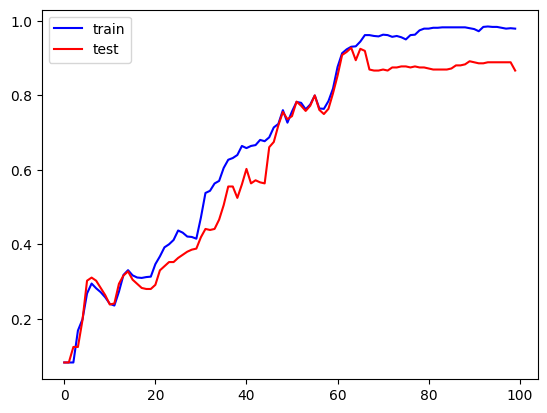

[70, 35]
(7041, 70, 12) (7041, 1)


  5%|▌         | 5/100 [00:00<00:01, 48.94it/s]

Epoch: 0 Train Loss: 2.5647 Train Acc: 0.1424 Test Acc: 0.1194


 20%|██        | 20/100 [00:00<00:01, 48.67it/s]

Epoch: 10 Train Loss: 2.5466 Train Acc: 0.2095 Test Acc: 0.2194


 30%|███       | 30/100 [00:00<00:01, 48.70it/s]

Epoch: 20 Train Loss: 2.4612 Train Acc: 0.2245 Test Acc: 0.2194


 40%|████      | 40/100 [00:00<00:01, 47.84it/s]

Epoch: 30 Train Loss: 2.3853 Train Acc: 0.3588 Test Acc: 0.3444


 50%|█████     | 50/100 [00:01<00:01, 46.55it/s]

Epoch: 40 Train Loss: 2.2507 Train Acc: 0.5532 Test Acc: 0.5333


 60%|██████    | 60/100 [00:01<00:00, 47.05it/s]

Epoch: 50 Train Loss: 2.1042 Train Acc: 0.6389 Test Acc: 0.6556


 70%|███████   | 70/100 [00:01<00:00, 47.50it/s]

Epoch: 60 Train Loss: 1.9831 Train Acc: 0.7396 Test Acc: 0.7389


 80%|████████  | 80/100 [00:01<00:00, 47.17it/s]

Epoch: 70 Train Loss: 1.9337 Train Acc: 0.7477 Test Acc: 0.7000


 90%|█████████ | 90/100 [00:01<00:00, 47.18it/s]

Epoch: 80 Train Loss: 1.8982 Train Acc: 0.8414 Test Acc: 0.7778


100%|██████████| 100/100 [00:02<00:00, 47.33it/s]

Epoch: 90 Train Loss: 1.8156 Train Acc: 0.8727 Test Acc: 0.8333


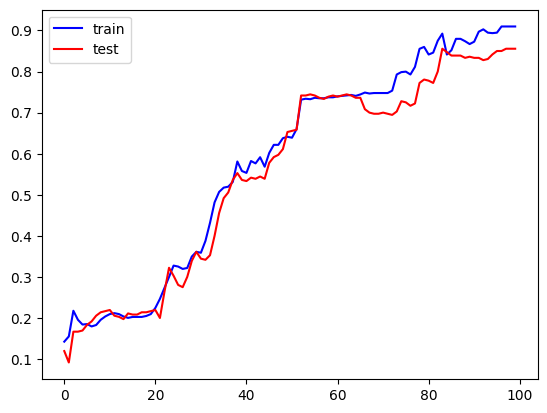

[80, 40]
(6161, 80, 12) (6161, 1)


  5%|▌         | 5/100 [00:00<00:02, 44.83it/s]

Epoch: 0 Train Loss: 2.5649 Train Acc: 0.0833 Test Acc: 0.0833


 15%|█▌        | 15/100 [00:00<00:01, 44.09it/s]

Epoch: 10 Train Loss: 2.5526 Train Acc: 0.3565 Test Acc: 0.3000


 25%|██▌       | 25/100 [00:00<00:01, 43.98it/s]

Epoch: 20 Train Loss: 2.4947 Train Acc: 0.4051 Test Acc: 0.3611


 35%|███▌      | 35/100 [00:00<00:01, 43.88it/s]

Epoch: 30 Train Loss: 2.3430 Train Acc: 0.5081 Test Acc: 0.4306


 45%|████▌     | 45/100 [00:01<00:01, 43.10it/s]

Epoch: 40 Train Loss: 2.1591 Train Acc: 0.6319 Test Acc: 0.5722


 55%|█████▌    | 55/100 [00:01<00:01, 43.17it/s]

Epoch: 50 Train Loss: 1.9902 Train Acc: 0.7188 Test Acc: 0.7444


 65%|██████▌   | 65/100 [00:01<00:00, 43.22it/s]

Epoch: 60 Train Loss: 1.8570 Train Acc: 0.8519 Test Acc: 0.7944


 75%|███████▌  | 75/100 [00:01<00:00, 43.64it/s]

Epoch: 70 Train Loss: 1.7947 Train Acc: 0.8762 Test Acc: 0.8222


 85%|████████▌ | 85/100 [00:01<00:00, 43.08it/s]

Epoch: 80 Train Loss: 1.7706 Train Acc: 0.9282 Test Acc: 0.8417


 95%|█████████▌| 95/100 [00:02<00:00, 43.20it/s]

Epoch: 90 Train Loss: 1.7236 Train Acc: 0.9630 Test Acc: 0.8583


100%|██████████| 100/100 [00:02<00:00, 43.44it/s]


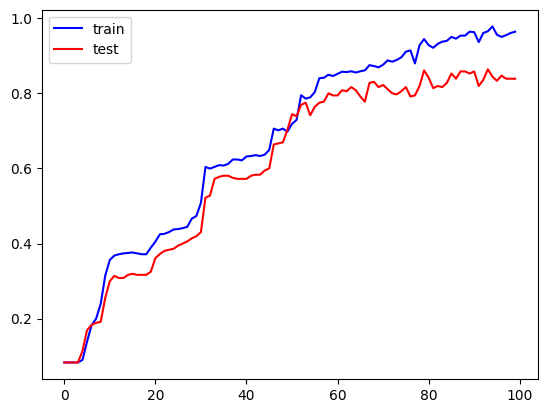

[90, 45]
(5476, 90, 12) (5476, 1)


  5%|▌         | 5/100 [00:00<00:02, 40.89it/s]

Epoch: 0 Train Loss: 2.5648 Train Acc: 0.1157 Test Acc: 0.0722


 18%|█▊        | 18/100 [00:00<00:02, 39.39it/s]

Epoch: 10 Train Loss: 2.5513 Train Acc: 0.2801 Test Acc: 0.2750


 26%|██▌       | 26/100 [00:00<00:01, 39.34it/s]

Epoch: 20 Train Loss: 2.4816 Train Acc: 0.3808 Test Acc: 0.4194


 38%|███▊      | 38/100 [00:00<00:01, 37.97it/s]

Epoch: 30 Train Loss: 2.2753 Train Acc: 0.5023 Test Acc: 0.4500


 46%|████▌     | 46/100 [00:01<00:01, 38.22it/s]

Epoch: 40 Train Loss: 2.0973 Train Acc: 0.6204 Test Acc: 0.5417


 58%|█████▊    | 58/100 [00:01<00:01, 38.80it/s]

Epoch: 50 Train Loss: 1.9710 Train Acc: 0.8102 Test Acc: 0.6583


 66%|██████▌   | 66/100 [00:01<00:00, 38.97it/s]

Epoch: 60 Train Loss: 1.8532 Train Acc: 0.8889 Test Acc: 0.7444


 78%|███████▊  | 78/100 [00:02<00:00, 38.46it/s]

Epoch: 70 Train Loss: 1.7715 Train Acc: 0.9606 Test Acc: 0.8306


 86%|████████▌ | 86/100 [00:02<00:00, 38.87it/s]

Epoch: 80 Train Loss: 1.7284 Train Acc: 0.9734 Test Acc: 0.7972


 98%|█████████▊| 98/100 [00:02<00:00, 38.95it/s]

Epoch: 90 Train Loss: 1.7185 Train Acc: 0.9769 Test Acc: 0.8417


100%|██████████| 100/100 [00:02<00:00, 38.84it/s]


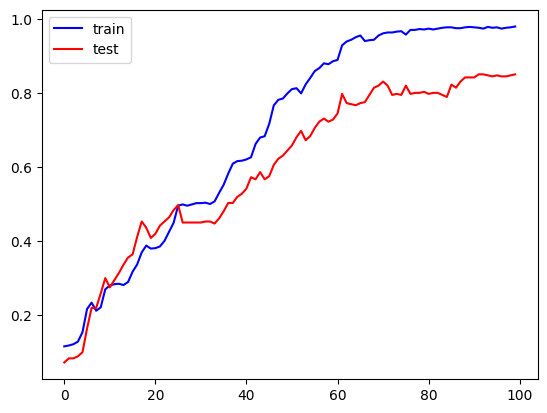

[100, 50]
(4929, 100, 12) (4929, 1)


  4%|▍         | 4/100 [00:00<00:02, 36.52it/s]

Epoch: 0 Train Loss: 2.5643 Train Acc: 0.1539 Test Acc: 0.1556


 16%|█▌        | 16/100 [00:00<00:02, 35.57it/s]

Epoch: 10 Train Loss: 2.5498 Train Acc: 0.2060 Test Acc: 0.1722


 28%|██▊       | 28/100 [00:00<00:02, 35.22it/s]

Epoch: 20 Train Loss: 2.4688 Train Acc: 0.3449 Test Acc: 0.3611


 36%|███▌      | 36/100 [00:01<00:01, 34.17it/s]

Epoch: 30 Train Loss: 2.3183 Train Acc: 0.5312 Test Acc: 0.5417


 48%|████▊     | 48/100 [00:01<00:01, 34.74it/s]

Epoch: 40 Train Loss: 2.1680 Train Acc: 0.6019 Test Acc: 0.6167


 56%|█████▌    | 56/100 [00:01<00:01, 34.87it/s]

Epoch: 50 Train Loss: 2.0373 Train Acc: 0.7373 Test Acc: 0.7083


 64%|██████▍   | 64/100 [00:01<00:01, 34.61it/s]

Epoch: 60 Train Loss: 1.9537 Train Acc: 0.7975 Test Acc: 0.7722


 76%|███████▌  | 76/100 [00:02<00:00, 34.37it/s]

Epoch: 70 Train Loss: 1.9194 Train Acc: 0.7951 Test Acc: 0.7528


 88%|████████▊ | 88/100 [00:02<00:00, 34.75it/s]

Epoch: 80 Train Loss: 1.8492 Train Acc: 0.8727 Test Acc: 0.8528


 96%|█████████▌| 96/100 [00:02<00:00, 34.93it/s]

Epoch: 90 Train Loss: 1.8060 Train Acc: 0.9039 Test Acc: 0.8861


100%|██████████| 100/100 [00:02<00:00, 34.75it/s]


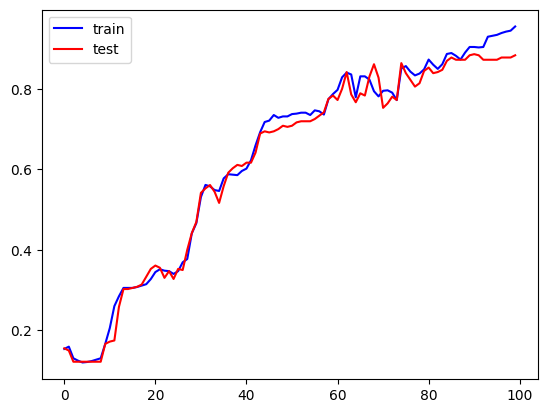

In [22]:
for i in steps:
    print(i)
    model = ConvLSTM12()
    modalTest(model, X_tr_modal3, y_tr_modal, X_ts_modal3, y_ts_modal, 100, i[0], i[1])

  2%|▏         | 2/100 [00:00<00:17,  5.51it/s]

Epoch: 0 Train Loss: 2.5639 Train Acc: 0.1000 Test Acc: 0.0956


 22%|██▏       | 22/100 [00:03<00:12,  6.35it/s]

Epoch: 20 Train Loss: 2.4910 Train Acc: 0.2193 Test Acc: 0.1888


 42%|████▏     | 42/100 [00:06<00:09,  6.22it/s]

Epoch: 40 Train Loss: 2.3046 Train Acc: 0.4181 Test Acc: 0.4336


 62%|██████▏   | 62/100 [00:09<00:06,  6.28it/s]

Epoch: 60 Train Loss: 2.1369 Train Acc: 0.5985 Test Acc: 0.6371


 82%|████████▏ | 82/100 [00:13<00:02,  6.22it/s]

Epoch: 80 Train Loss: 1.9795 Train Acc: 0.7192 Test Acc: 0.6807


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


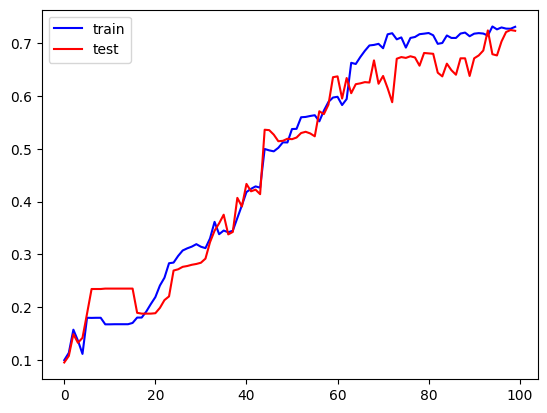

In [276]:
model = ConvLSTM6()
modalTest(model, X_tr_modal1, y_tr_modal, X_ts_modal1, y_ts_modal, 100)

  2%|▏         | 2/100 [00:00<00:18,  5.21it/s]

Epoch: 0 Train Loss: 2.5645 Train Acc: 0.0935 Test Acc: 0.0901


 22%|██▏       | 22/100 [00:03<00:12,  6.43it/s]

Epoch: 20 Train Loss: 2.5067 Train Acc: 0.3222 Test Acc: 0.2393


 42%|████▏     | 42/100 [00:06<00:09,  6.35it/s]

Epoch: 40 Train Loss: 2.1759 Train Acc: 0.5630 Test Acc: 0.5167


 62%|██████▏   | 62/100 [00:09<00:06,  6.18it/s]

Epoch: 60 Train Loss: 2.0140 Train Acc: 0.7154 Test Acc: 0.6177


 82%|████████▏ | 82/100 [00:13<00:02,  6.25it/s]

Epoch: 80 Train Loss: 1.9478 Train Acc: 0.7371 Test Acc: 0.6550


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]


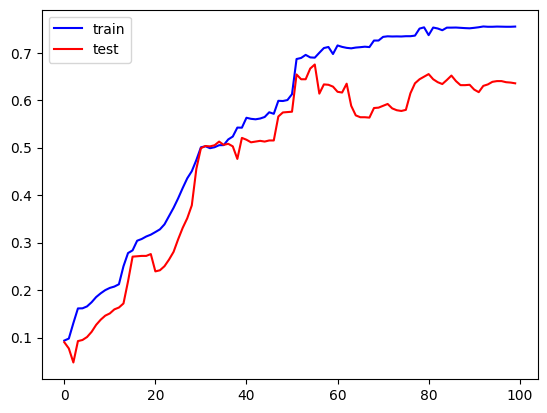

In [274]:
model = ConvLSTM6()
modalTest(model, X_tr_modal1, y_tr_modal, X_ts_modal1, y_ts_modal, 100)

  2%|▏         | 2/100 [00:00<00:18,  5.41it/s]

Epoch: 0 Train Loss: 2.5651 Train Acc: 0.0747 Test Acc: 0.0653


 22%|██▏       | 22/100 [00:03<00:12,  6.30it/s]

Epoch: 20 Train Loss: 2.4916 Train Acc: 0.3439 Test Acc: 0.3395


 42%|████▏     | 42/100 [00:06<00:09,  6.33it/s]

Epoch: 40 Train Loss: 2.2136 Train Acc: 0.5498 Test Acc: 0.4957


 62%|██████▏   | 62/100 [00:09<00:06,  6.21it/s]

Epoch: 60 Train Loss: 2.0755 Train Acc: 0.6354 Test Acc: 0.5594


 82%|████████▏ | 82/100 [00:13<00:02,  6.17it/s]

Epoch: 80 Train Loss: 2.0364 Train Acc: 0.6517 Test Acc: 0.5835


100%|██████████| 100/100 [00:16<00:00,  6.25it/s]


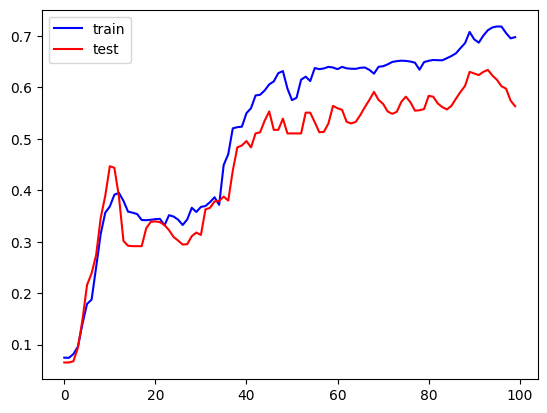

In [223]:
model = ConvLSTM6()
modalTest(model, X_tr_modal2, y_tr_modal, X_ts_modal2, y_ts_modal, 100)

  1%|          | 2/200 [00:00<00:34,  5.69it/s]

Epoch: 0 Train Loss: 2.5652 Train Acc: 0.1609 Test Acc: 0.1647


 11%|█         | 22/200 [00:03<00:27,  6.48it/s]

Epoch: 20 Train Loss: 2.4908 Train Acc: 0.4267 Test Acc: 0.5315


 21%|██        | 42/200 [00:06<00:24,  6.50it/s]

Epoch: 40 Train Loss: 2.0726 Train Acc: 0.6304 Test Acc: 0.6022


 31%|███       | 62/200 [00:09<00:21,  6.47it/s]

Epoch: 60 Train Loss: 1.9339 Train Acc: 0.7604 Test Acc: 0.7366


 41%|████      | 82/200 [00:12<00:18,  6.37it/s]

Epoch: 80 Train Loss: 1.8814 Train Acc: 0.8426 Test Acc: 0.8003


 51%|█████     | 102/200 [00:15<00:15,  6.42it/s]

Epoch: 100 Train Loss: 1.8097 Train Acc: 0.8811 Test Acc: 0.8415


 61%|██████    | 122/200 [00:18<00:12,  6.36it/s]

Epoch: 120 Train Loss: 1.7972 Train Acc: 0.8825 Test Acc: 0.8081


 71%|███████   | 142/200 [00:22<00:09,  6.39it/s]

Epoch: 140 Train Loss: 1.7942 Train Acc: 0.8943 Test Acc: 0.8104


 81%|████████  | 162/200 [00:25<00:06,  6.27it/s]

Epoch: 160 Train Loss: 1.7925 Train Acc: 0.8949 Test Acc: 0.8081


 91%|█████████ | 182/200 [00:28<00:02,  6.28it/s]

Epoch: 180 Train Loss: 1.7920 Train Acc: 0.8949 Test Acc: 0.7646


100%|██████████| 200/200 [00:31<00:00,  6.37it/s]


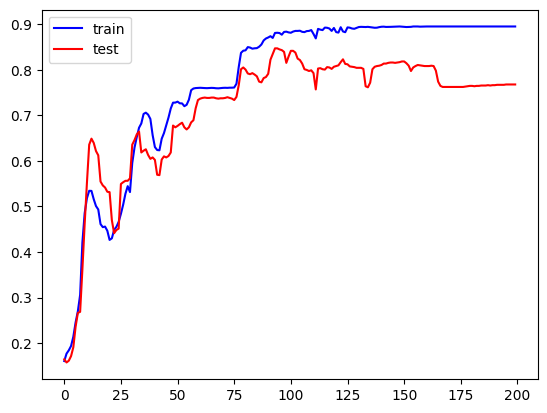

In [225]:
model = ConvLSTM12()
modalTest(model, X_tr_modal3, y_tr_modal, X_ts_modal3, y_ts_modal, 200)

In [44]:
with open('./balanced_weights/modal1_weights.pickle', 'rb') as f:
    weights1 = pickle.load(f)
with open('./balanced_weights/modal2_weights.pickle', 'rb') as f:
    weights2 = pickle.load(f)
with open('./balanced_weights/modal3_weights.pickle', 'rb') as f:
    weights3 = pickle.load(f)

In [71]:
model = ConvLSTM12()

In [72]:
model.state_dict()['bn2.num_batches_tracked']

tensor(0)

In [108]:
model.state_dict()['fc2.bias'].shape

torch.Size([13])

In [109]:
weights1[22:][3].shape

(13,)

In [ ]:
def get_parameter():
    parameters = []
    for i in range(1, 4):
        with open('/home/jhmoon/venvFL/2023-paper-Federated_Learning/multiFL/mHealth/balanced_weights/modal'+i+'_weights.pickle', 'rb') as f:
            data = pickle.load(f)
            parameters.append(data)

    avg_params = []

    for i in range(22, 26):
        avg_params.append((parameters[0][i] + parameters[1][i] + parameters[2][i]) / 3)
    
    for i in range(22, 26):
        parameters[0][i] = avg_params[i-22]
        parameters[1][i] = avg_params[i-22]
        parameters[2][i] = avg_params[i-22]

    return parameters

In [112]:
parameters = []
for i in range(1, 4):
    with open('/home/jhmoon/venvFL/2023-paper-Federated_Learning/multiFL/mHealth/balanced_weights/modal'+str(i)+'_weights.pickle', 'rb') as f:
        data = pickle.load(f)
        parameters.append(data)

In [140]:
parameters[0][23].shape

(128,)

In [123]:
avg_params = []

for i in range(22, 26):
    avg_params.append((parameters[0][i] + parameters[1][i] + parameters[2][i]) / 3)

In [141]:
avg_params[1].shape

(128,)